# Verify the working of the blocks
- Copy over all the blocks.
- Simulate them imdependently.
- Vefity `vmap`
- Verify activation.
- Implement quantization.


## Progress till 1/15/25
- Weights quantized ✅ (caveat: not quantized within some rails but the rails are min/max values of parameters)
- Blocks running  ✅
- Training works ~92% with `relu`  ✅
- Rommani also has data showing training works for `silu`
- Training does NOT work with binary case ❌
- Inference works with `relu` and `silu`  ✅
- Inference does NOT work with binary case ❌

In [25]:
import jax
import jax.numpy as jnp
import optax
import flax
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from flax import linen as nn
from flax.training import train_state
# from EICDense import *
# from ShuffleBlock import *
# from Accumulator import *
# from PseudoFFNet import *
# from EICNet import *
from HelperFunctions.binary_trident_helper_functions import *
from HelperFunctions.binary_mnist_dataloader import *
from HelperFunctions.metric_functions import *

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def quantize_params(params, bits = 8):
    """
    Quantizes the parameters of the model to given number of bits.
    Args:
        params: flax model parameters
        bits: number of bits to quantize to
    Returns:
        quantized_params: quantized flax model parameters
    """

    scale = 2**(bits - 1) - 1
    params = jax.tree.map(
        lambda p: jnp.round(p * scale) / scale, params
    )

    return params

## testing
params = {
    'weights': jnp.array([0.001, 0.2345, 0.21, -0.9, 1.32, -7.234])
}
print(params)
quantized_params = quantize_params(params, bits = 8)
print(quantized_params)

{'weights': Array([ 1.000e-03,  2.345e-01,  2.100e-01, -9.000e-01,  1.320e+00,
       -7.234e+00], dtype=float32)}
{'weights': Array([ 0.        ,  0.23622048,  0.21259843, -0.8976378 ,  1.3228346 ,
       -7.2362204 ], dtype=float32)}


## EICDense

In [3]:
class EICDense(nn.Module):
    """
    Pseudo-dense layer using EIC Cores.
    Args:
    in_size: int, number of input neurons
    out_size: int, number of output neurons
    threshold: float, threshold for binary activation
    noise_sd: flaat, standard deviation of noise for binary activation
    key: jax.random.PRNGKey, random key

    Returns:
    x: jnp.ndarray, output of the layer
    """

    in_size: int
    out_size: int
    # threshold: float
    # noise_sd: float
    # activation: callable

    def setup(self):
        """
        Set up dependent parameters
        """
        self.out_blocks = max(self.out_size//256, 1) # number of blocks required at the output 
        self.in_blocks = max(self.in_size//256, 1) # number of bloacks required at the input


        self.num_cores = self.out_blocks * self.in_blocks # number of cores required
        self.W = self.param(
            "weights",
            lambda key, shape: nn.initializers.xavier_normal()(key, shape),
            (self.out_blocks, self.in_blocks, 256, 256)
        )


    # @staticmethod
    # def linear_map(x, threshold = 0., noise_sd = 0.1, key = None):
    #     """
    #     Linear map
    #     """
    #     return x

    # @staticmethod
    # def sigmoid_fn(x, threshold = 0.0, noise_sd = 0.1, key = jax.random.key(0)):
    #     """
    #     Simple sigmoid.
    #     """
    #     return jax.nn.sigmoid(x)
    
    # def relu_fn(self, x, threshold = 0.0, noise_sd = 0.1, key = jax.random.key(0)):
    #     """
    #     Simple ReLU.
    #     """
    #     return jax.nn.relu(x)

    def __call__(self, x):
        """
        Forward pass of the layer
        Args:
        x: jnp.ndarray (batch_size, in_size), input to the layer
        
        Returns:
        x: jnp.ndarray, output of the layer
        """

        assert x.shape[-1] == self.in_size, f"Input shape is incorrect. Got {x.shape[-1]}, expected {self.in_size}"

        x_reshaped = x.reshape(x.shape[0], self.in_blocks, 256) # organize x into blocks of 256 for every batch

        # make sure that the weights are positive
        W_pos= jax.nn.softplus(self.W)

        # quantize weights
        W_pos = quantize_params(W_pos, bits = 8)

        y = jnp.einsum("ijkl,bjl->bijk", W_pos, x_reshaped)

        # activation_fn = self.activation if self.activation is not None else self.linear_map
 
        # key = self.make_rng("activation")
        # y = activation_fn(y, threshold = self.threshold, noise_sd = self.noise_sd, key = key)

        return y
    
    
# testing...

# rng = jax.random.key(0)
# key, subkey = jax.random.split(rng)
# x = jax.random.normal(key, (1024,))
# eic = EICDense(in_size = 1024, out_size = 2048, threshold=0., activation = custom_binary_gradient, noise_sd = 0.1)
# params_eic = eic.init(key, x)
# print("Initialized EICDense parameters")
# print(f"Params: {params_eic}")
# print(f"Params shape: {params_eic['params']['weights'].shape}")
# y = eic.apply(params_eic, x, rngs = {"activation": subkey})
# print(f"Output: {y}")
# print(f"Output shape: {y.shape}")





## Accumulator


In [4]:
# define the accumulator module
class Accumulator(nn.Module):
    """
    Accumulating the EICDense outputs. 
    Since the EICDense generates pseudo-feedforward outputs, we use a learnable accumulation matrix that minimizes error
    between the true feedforward output and the EIC output.

    Args:
        in_block_size: int, number of 256-sized blocks. This should be the .shape[0] of the EICDense output
    """

    in_block_size: int
    # threshold: float
    # noise_sd: float
    # activation: callable = None

    def setup(self):
        """
        Set up the weights for the accumulator
        """

        self.W = self.param(
            "weights",
            nn.initializers.xavier_normal(),
            (self.in_block_size, 256, 256)
        )

    @staticmethod
    def linear_map(x, threshold = 0., noise_sd = 0.1, key = None):
        """
        Linear map
        """
        return x


    @nn.compact
    def __call__(self, x):
        """
        Forward pass of the accumulator
        Args:
        x: jnp.ndarray, input to the accumulator
        
        Returns:
        x: jnp.ndarray, output of the accumulator
        """

        assert x.shape[1] == self.in_block_size, "Input shape is incorrect"
        # assert x.shape[1] == self.out_block_size, "Input shape is incorrect"

        # ensure positive 
        W_pos = jax.nn.softplus(self.W)
        W_pos = quantize_params(W_pos, bits = 8)
        
        x = jnp.einsum("bijk->bik", x)
        y = jnp.einsum("ijk,bik->bik", W_pos, x) 


        # y = jnp.einsum('ijk,imk->ij', W_pos, x) #jnp.einsum('imk,ijk->im', W_pos, x) #
        # key = self.make_rng("activation")

        # activation_fn = self.activation if self.activation is not None else self.linear_map
        # y = activation_fn(y, threshold = self.threshold, noise_sd = self.noise_sd, key = key)

        # flatten y before returning
        y = y.reshape((y.shape[0], -1)) # (batch_size, out_size)

        return y

# testing...
# def __main__():
#     rng = jax.random.key(42)
#     x = jax.random.normal(rng, (8, 4, 256))
#     acc = Accumulator(
#         in_block_size = x.shape[0],
#         threshold = 0.0,
#         noise_sd = 1.0,
#         activation = custom_binary_gradient
#     )

#     params = acc.init(rng, x)
#     print("Initialized accumulator parameters")
#     print("----------------------------------------")
#     print(f"Output shape: {params["params"]["weights"].shape}")
#     y = acc.apply(params, x, rngs = {"activation": rng})
#     print("----------------------------------------")
#     print(f"Accumulator output {y}, \n Output shape: {y.shape}")


# if __name__ == "__main__":
#     __main__()

## Simplified accumulator
- Simply accumulates over contracting dimension

In [5]:
# define the accumulator module
class SimpleAccumulator(nn.Module):
    """
    Accumulating the EICDense outputs. 
    Since the EICDense generates pseudo-feedforward outputs, we use a learnable accumulation matrix that minimizes error
    between the true feedforward output and the EIC output.

    Args:
        in_block_size: int, number of 256-sized blocks. This should be the .shape[0] of the EICDense output
    """

    in_block_size: int
    # threshold: float
    # noise_sd: float
    # activation: callable = None

    # def setup(self):
    #     """
    #     Set up the weights for the accumulator
    #     """

    #     self.W = self.param(
    #         "weights",
    #         nn.initializers.xavier_normal(),
    #         (self.in_block_size, 256, 256)
    #     )


    @nn.compact
    def __call__(self, x):
        """
        Forward pass of the accumulator
        Args:
        x: jnp.ndarray, input to the accumulator
        
        Returns:
        x: jnp.ndarray, output of the accumulator
        """

        assert x.shape[1] == self.in_block_size, "Input shape is incorrect"
        # assert x.shape[1] == self.out_block_size, "Input shape is incorrect"

        
        y = jnp.einsum("bijk->bik", x)
        

        # flatten y before returning
        y = y.reshape((y.shape[0], -1)) # (batch_size, out_size)

        return y

# testing...
# def __main__():
#     rng = jax.random.key(42)
#     x = jax.random.normal(rng, (8, 4, 256))
#     acc = Accumulator(
#         in_block_size = x.shape[0],
#         threshold = 0.0,
#         noise_sd = 1.0,
#         activation = custom_binary_gradient
#     )

#     params = acc.init(rng, x)
#     print("Initialized accumulator parameters")
#     print("----------------------------------------")
#     print(f"Output shape: {params["params"]["weights"].shape}")
#     y = acc.apply(params, x, rngs = {"activation": rng})
#     print("----------------------------------------")
#     print(f"Accumulator output {y}, \n Output shape: {y.shape}")


# if __name__ == "__main__":
#     __main__()

## Shuffle Block

In [6]:
## define a module to split the input and shuffle it in blocks of 64

class ShuffleBlock(nn.Module):
    """
    Defines a trainable permutation matrix with a temperature parameter.
    This is a proxy for the lookup table. In some sense it describes an idealized LUT.
    Temperature parameter can be very loosely interpreted as "release probability"

    Args:
        input_size: int, size of the input (e.g. 2048)
    Defines:
        A: jnp.ndarray, trainable permutation matrix
        tau: float, temperature parameter
    Returns:
        y: jnp.ndarray, shuffled input. Basically, y = Ax
    """

    input_size: int
    tau: float 

    def setup(self):
        """
        Set up trainable permutation matrix
        """

        self.Zpos = self.param(
            'Zpos',
            nn.initializers.xavier_normal(),
            (self.input_size, self.input_size)
        )

        self.Zneg = self.param(
            'Zneg',
            nn.initializers.xavier_normal(),
            (self.input_size, self.input_size)
        )

    
    def __call__(self, x):
        """
        Soft shuffle the input
        """

        Ppos = jax.nn.softmax(self.Zpos/self.tau, axis = -1)
        Pneg = jax.nn.softmax(self.Zneg/self.tau, axis = -1)

        xpos = jnp.einsum('ij,bj->bi', Ppos, x)
        xneg = jnp.einsum('ij,bj->bi', Pneg, x)

        # P = jax.nn.softmax(self.Z/self.tau, axis = -1) * jnp.sign(self.Z)
        y = xpos - xneg

        return y
    
# testing...
sh1 = ShuffleBlock(input_size = 256, tau = 0.5)
key = jax.random.key(1)
x = jnp.ones((10, 256))
params = sh1.init(key, x)
out = sh1.apply(params, x)

print(f"Output shape: {out.shape}")
print(f"Output: {out}")
  

Output shape: (10, 256)
Output: [[ 1.1920929e-07  4.1723251e-07  5.9604645e-08 ...  1.1920929e-07
  -2.9802322e-07 -5.9604645e-08]
 [ 1.1920929e-07  4.1723251e-07  5.9604645e-08 ...  1.1920929e-07
  -2.9802322e-07 -5.9604645e-08]
 [ 1.1920929e-07  4.1723251e-07  5.9604645e-08 ...  1.1920929e-07
  -2.9802322e-07 -5.9604645e-08]
 ...
 [ 1.1920929e-07  4.1723251e-07  5.9604645e-08 ...  1.1920929e-07
  -2.9802322e-07 -5.9604645e-08]
 [ 1.1920929e-07  4.1723251e-07  5.9604645e-08 ...  1.1920929e-07
  -2.9802322e-07 -5.9604645e-08]
 [ 1.1920929e-07  4.1723251e-07  5.9604645e-08 ...  1.1920929e-07
  -2.9802322e-07 -5.9604645e-08]]


## Permute Block
- Contains two fixed non-trainable matrices to permute the inputs in blocks of M (= 16 or 64).

In [7]:
class PermuteBlock(nn.Module):
    """
    Contains two fixed permutation matrices (pos and neg) to shuffle the input block-wise.
    """

    input_size: int
    permute_block_size: int = 16 # previously 64
    core_input_size: int = 256

    def setup(self):
        """
        Set up permutation matrices
        """


        self.num_slots = self.core_input_size // self.permute_block_size # should be 16 in the latest iteration
        self.num_subvectors = self.input_size // self.core_input_size # for input_size = 1024, should be 256

        # generate two independent permutation sequences
        key = jax.random.key(1245)
        key1, key2 = jax.random.split(key)
        p1 = jax.random.permutation(key1, self.num_slots)
        p2 = jnp.roll(p1, shift = 1) #jax.random.permutation(key2, self.num_slots)

        # generate permutation matrices
        m1 = jnp.eye(self.num_slots)
        m2 = jnp.eye(self.num_slots)

        # generate the permutation matrices
        self.Ppos = m1[p1]
        self.Pneg = m2[p2]

    
    def __call__(self, x):
        """
        Apply permutations and return (xpos - xneg)
        Args:
        x: jnp.ndarray, input vector. Shape: (batch_size, input_size) e.g. (32, 2048)
        Returns:
        xpos - xneg: jnp.ndarray, difference of permuted inputs. Shape: (batch_size, input_size)
        """

        assert x.shape[-1] == self.input_size, f"Input shape is incorrect. Got {x.shape[-1]}, expected {self.input_size}"
        assert self.num_subvectors * self.num_slots * self.permute_block_size == self.input_size, f"Inconsistent metrics!"

        x = x.reshape(x.shape[0], self.num_subvectors, self.num_slots, self.permute_block_size) # first dimension must be the batch size

        xpos = jnp.einsum('ij,bsjp->bsip', self.Ppos, x)
        xneg = jnp.einsum('ij,bsjp->bsip', self.Pneg, x)

        xout = xpos - xneg

        xout = xout.reshape((x.shape[0], self.input_size))

        return jax.lax.stop_gradient(xout)
    
# testing ...
key = jax.random.key(0)
key1, key2 = jax.random.split(key)

ta1 = jnp.concatenate((jnp.arange(256)[:, None], jnp.arange(256)[:, None]), axis = 1).T
print(ta1.shape)

p1 = PermuteBlock(input_size = 256)
_ = p1.init(key, ta1)
out = p1.apply(_, ta1)

print(out)

(2, 256)
[[ 192.  192.  192.  192.  192.  192.  192.  192.  192.  192.  192.  192.
   192.  192.  192.  192. -240. -240. -240. -240. -240. -240. -240. -240.
  -240. -240. -240. -240. -240. -240. -240. -240.  224.  224.  224.  224.
   224.  224.  224.  224.  224.  224.  224.  224.  224.  224.  224.  224.
   -96.  -96.  -96.  -96.  -96.  -96.  -96.  -96.  -96.  -96.  -96.  -96.
   -96.  -96.  -96.  -96.  -96.  -96.  -96.  -96.  -96.  -96.  -96.  -96.
   -96.  -96.  -96.  -96.  -96.  -96.  -96.  -96.   80.   80.   80.   80.
    80.   80.   80.   80.   80.   80.   80.   80.   80.   80.   80.   80.
   -32.  -32.  -32.  -32.  -32.  -32.  -32.  -32.  -32.  -32.  -32.  -32.
   -32.  -32.  -32.  -32.  128.  128.  128.  128.  128.  128.  128.  128.
   128.  128.  128.  128.  128.  128.  128.  128. -144. -144. -144. -144.
  -144. -144. -144. -144. -144. -144. -144. -144. -144. -144. -144. -144.
    32.   32.   32.   32.   32.   32.   32.   32.   32.   32.   32.   32.
    32.   32.   32.   32.   6

In [8]:
# key = jax.random.key(0)
# key1, key2 = jax.random.split(key)

# p1 = jax.random.permutation(key1, 16)
# p2 = jax.random.permutation(key2, 16)

# print(f"{p1} \n {p2}")

# mat1 = jnp.eye(16)
# mat2 = jnp.eye(16)

# mat1 = mat1[p1]
# mat2 = mat2[p2]

# # print(f"{mat1} \n {mat2}")

# ta1 = jnp.concatenate((jnp.arange(16)[:, None], jnp.arange(16)[:, None]), axis = 1)
# print(ta1)
# a1 = jnp.einsum('ij,jk->ik', mat1, ta1)
# a2 = jnp.einsum('ij,jk->ik', mat2, ta1)
# print(a1 - a2)

arr = jnp.arange(10)
print(jnp.roll(arr, shift = 4))


[6 7 8 9 0 1 2 3 4 5]


## Network

In [90]:
class EICNet(nn.Module):
    """
    EICNetwork -> Might supersede PseudoFFNet... in progress
    1024 - 2048 - 256 - 10
    """
    def setup(self):
        # self.p1 = PermuteBlock(input_size = 16*16)
        self.fc1 = EICDense(in_size = 16*16, out_size = 2048) # (8, 4, 256)
        self.ac1 = SimpleAccumulator(in_block_size = 2048//256) # (2048,)
        self.p2 = PermuteBlock(input_size = 2048)
        self.fc2 = EICDense(in_size = 2048, out_size = 512) # (8, 4, 256)
        self.ac2 = SimpleAccumulator(in_block_size = 512//256) # (2048,)
        self.p3 = PermuteBlock(input_size = 512)
        self.fc3 = EICDense(in_size = 512, out_size = 256) # (8, 4, 256)
        self.ac3 = SimpleAccumulator(in_block_size = 256//256) # (2048,)

    def __call__(self, x):
        nsd = 0.5
        x = x.reshape((x.shape[0], 16*16))
        # x = self.p1(x)
        print(x.shape)
        x = self.fc1(x)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = jax.random.key(0)) #jax.nn.relu(x) # custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = jax.random.key(0))
        x = self.ac1(x)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = jax.random.key(0))
        x = self.p2(x)
        x = self.fc2(x)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = jax.random.key(0))
        x = self.ac2(x)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = jax.random.key(0))
        x = self.p3(x)
        x = self.fc3(x)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = jax.random.key(0))
        x = self.ac3(x)
        x = x[:, :10]
        return x

## Make a binary network

In [10]:
class EICNetBinary(nn.Module):
    """
    EICNetwork -> Might supersede PseudoFFNet... in progress
    1024 - 2048 - 256 - 10
    """
    def setup(self):
        temp = 0.9
        # self.sh1 = ShuffleBlock(input_size = 16*16, tau = temp)
        self.fc1 = EICDense(in_size = 16*16, out_size = 2048) # (8, 4, 256)
        self.ac1 = Accumulator(in_block_size = 2048//256) # (2048,)
        self.sh2 = ShuffleBlock(input_size = 2048, tau = temp)
        self.fc2 = EICDense(in_size = 2048, out_size = 512) # (8, 4, 256)
        self.ac2 = Accumulator(in_block_size = 512//256) # (2048,)
        self.sh3 = ShuffleBlock(input_size = 512, tau = temp)
        self.fc3 = EICDense(in_size = 512, out_size = 256) # (8, 4, 256)
        self.ac3 = Accumulator(in_block_size = 256//256) # (2048,)

    def __call__(self, x):
        x = x.reshape((x.shape[0], 16*16))
        # x = self.sh1(x)
        key, subkey = jax.random.split(jax.random.PRNGKey(0))
        x = self.fc1(x)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = subkey)
        x = self.ac1(x)
        key, subkey = jax.random.split(key)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = subkey)
        x = self.sh2(x)
        x = self.fc2(x)
        key, subkey = jax.random.split(key)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = subkey)
        x = self.ac2(x)
        key, subkey = jax.random.split(key)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = subkey)
        x = self.sh3(x)
        x = self.fc3(x)
        key, subkey = jax.random.split(key)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = subkey)
        x = self.ac3(x)
        x = x[:, :10]
        return x

## Conv Net

In [58]:
class EICConvNet(nn.Module):
    """
    EICNetwork -> Might supersede PseudoFFNet... in progress
    1024 - 2048 - 256 - 10
    """
    def setup(self):
        # self.p1 = PermuteBlock(input_size = 16*16)
        self.conv1 = nn.Conv(features = 1, kernel_size = (4,4), padding=3, strides=2)
        self.fc1 = EICDense(in_size = 16*16, out_size = 2048) # (8, 4, 256)
        self.ac1 = SimpleAccumulator(in_block_size = 2048//256) # (2048,)
        self.p2 = PermuteBlock(input_size = 2048)
        self.fc2 = EICDense(in_size = 2048, out_size = 512) # (8, 4, 256)
        self.ac2 = SimpleAccumulator(in_block_size = 512//256) # (2048,)
        self.p3 = PermuteBlock(input_size = 512)
        self.fc3 = EICDense(in_size = 512, out_size = 256) # (8, 4, 256)
        self.ac3 = SimpleAccumulator(in_block_size = 256//256) # (2048,)

    def __call__(self, x):
        x = self.conv1(x)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = jax.random.key(0))
        x = nn.avg_pool(x, window_shape=(4, 4), strides=(1, 1), padding='SAME')
        x = x.reshape((x.shape[0], 16*16))
        print(x.shape)
        # x = self.p1(x)
        print(x.shape)
        x = self.fc1(x)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = jax.random.key(0)) #jax.nn.relu(x) # custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = jax.random.key(0))
        x = self.ac1(x)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = jax.random.key(0))
        x = self.p2(x)
        x = self.fc2(x)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = jax.random.key(0))
        x = self.ac2(x)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = jax.random.key(0))
        x = self.p3(x)
        x = self.fc3(x)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = jax.random.key(0))
        x = self.ac3(x)
        x = x[:, :10]
        return x

In [57]:
# testing...
conv1 = nn.Conv(features=1, kernel_size=(4, 4), strides=(2, 2), padding=3)
x = jnp.ones((10, 28, 28, 1))
params = conv1.init(jax.random.PRNGKey(0), x)
out = conv1.apply(params, x)
out = nn.avg_pool(out, window_shape=(4, 4), strides=(1,1), padding="SAME")
print(out.shape)

(10, 16, 16, 1)


In [59]:
# some additional functions
def cross_entropy_loss(*, logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes = 10)
    loss = optax.softmax_cross_entropy(logits = logits, labels = one_hot_labels).mean()
    return loss

# testing...
key = jax.random.key(1)
logits = jax.random.normal(key, (10,))
print(logits, jnp.argmax(logits))
label = 9
loss = cross_entropy_loss(logits = logits, labels = label)

print(loss)


[ 0.690805   -0.48744103 -1.155789    0.12108463 -0.19598432 -0.5078766
  0.91568655  1.70968    -0.36749417  0.14315689] 7
2.5878873


In [67]:
# load the data
DATA_PATH = f"/Users/vikrantjaltare/OneDrive - UC San Diego/Datasets/"
# (train_inputs, train_labels), (val_inputs, val_labels), (test_inputs, test_labels) = load_and_process_mnist(data_path=DATA_PATH, binarize = True)
# train_inputs[0].shape

def get_datasets():
    """Load MNIST train, validation, and test datasets into memory."""
    # Load MNIST dataset
    ds_builder = tfds.builder('mnist', data_dir=DATA_PATH)
    ds_builder.download_and_prepare()
    
    # Load full datasets as numpy arrays
    full_train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    full_test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))

    # Normalize images
    full_train_ds['image'] = jnp.float32(full_train_ds['image']) / 255.
    full_test_ds['image'] = jnp.float32(full_test_ds['image']) / 255.

    # Concatenate train and test datasets for splitting
    all_images = jnp.concatenate([full_train_ds['image'], full_test_ds['image']], axis=0)
    all_labels = jnp.concatenate([full_train_ds['label'], full_test_ds['label']], axis=0)

    # Train-validation-test split: 50k-10k-10k
    train_images, val_images, test_images = all_images[:50000], all_images[50000:60000], all_images[60000:]
    train_labels, val_labels, test_labels = all_labels[:50000], all_labels[50000:60000], all_labels[60000:]

    # Resize images to 16x16
    def resize_images(images, new_size):
        resized = tf.image.resize(images, new_size, method='bilinear')
        return jnp.array(resized)

    train_images = resize_images(train_images, (16, 16))
    val_images = resize_images(val_images, (16, 16))
    test_images = resize_images(test_images, (16, 16))

    # Binarize images
    def binarize_images(images, threshold=0.5):
        return jnp.where(images < threshold, 0.0, 1.0)

    train_images = binarize_images(train_images)
    val_images = binarize_images(val_images)
    test_images = binarize_images(test_images)

    # Prepare datasets in similar structure as original
    train_ds = {'image': train_images, 'label': train_labels}
    val_ds = {'image': val_images, 'label': val_labels}
    test_ds = {'image': test_images, 'label': test_labels}

    return train_ds, val_ds, test_ds


def get_datasets_28():
    """Load MNIST train, validation, and test datasets into memory."""
    # Load MNIST dataset
    ds_builder = tfds.builder('mnist', data_dir=DATA_PATH)
    ds_builder.download_and_prepare()
    
    # Load full datasets as numpy arrays
    full_train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    full_test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))

    # Normalize images
    full_train_ds['image'] = jnp.float32(full_train_ds['image']) / 255.
    full_test_ds['image'] = jnp.float32(full_test_ds['image']) / 255.

    # Concatenate train and test datasets for splitting
    all_images = jnp.concatenate([full_train_ds['image'], full_test_ds['image']], axis=0)
    all_labels = jnp.concatenate([full_train_ds['label'], full_test_ds['label']], axis=0)

    # Train-validation-test split: 50k-10k-10k
    train_images, val_images, test_images = all_images[:50000], all_images[50000:60000], all_images[60000:]
    train_labels, val_labels, test_labels = all_labels[:50000], all_labels[50000:60000], all_labels[60000:]

    # Resize images to 16x16
    def resize_images(images, new_size):
        resized = tf.image.resize(images, new_size, method='bilinear')
        return jnp.array(resized)

    # train_images = resize_images(train_images, (16, 16))
    # val_images = resize_images(val_images, (16, 16))
    # test_images = resize_images(test_images, (16, 16))

    # Binarize images
    def binarize_images(images, threshold=0.5):
        return jnp.where(images < threshold, 0.0, 1.0)

    train_images = binarize_images(train_images)
    val_images = binarize_images(val_images)
    test_images = binarize_images(test_images)

    # Prepare datasets in similar structure as original
    train_ds = {'image': train_images, 'label': train_labels}
    val_ds = {'image': val_images, 'label': val_labels}
    test_ds = {'image': test_images, 'label': test_labels}

    return train_ds, val_ds, test_ds


In [68]:
train_ds, val_ds, test_ds = get_datasets_28()

print(f"Train dataset size: {len(train_ds['image'])}")
print(f"Validation dataset size: {len(val_ds['image'])}")
print(f"Test dataset size: {len(test_ds['image'])}")
print(f"Image shape: {train_ds['image'][0].shape}")

Train dataset size: 50000
Validation dataset size: 10000
Test dataset size: 10000
Image shape: (28, 28, 1)


4


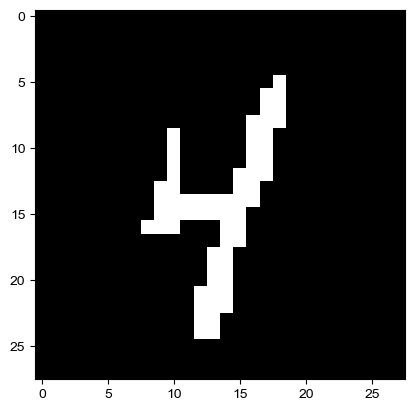

In [69]:
im = train_ds['image'][0]
ll = train_ds['label'][0]

plt.imshow(im, cmap = 'gray')
print(ll)

In [15]:
perm = jax.random.permutation(jax.random.PRNGKey(0), len(train_ds['image']))
batch = {k: v[perm, ...] for k, v in train_ds.items()}

print(batch)
del batch


{'image': Array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

      

In [60]:
def compute_metrics(*, logits, labels):
  loss = cross_entropy_loss(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

# create train state
def create_train_state(rng, learning_rate, batch_size, momentum = 0.9):
  """
  Create a training state for Flax
  """

  eic_model = EICNet()
  params = eic_model.init(rng, jnp.ones((1, 16*16)))['params']
  # opt = optax.sgd(learning_rate = learning_rate, momentum= momentum)
  opt = optax.adam(learning_rate=learning_rate)
  return train_state.TrainState.create(
    apply_fn=eic_model.apply, params=params, tx=opt
  )

# create train state for conv net
def create_train_state_conv(rng, learning_rate, batch_size, momentum = 0.9):
  """
  Create a training state for Flax
  """

  eic_model = EICConvNet()
  params = eic_model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  # opt = optax.sgd(learning_rate = learning_rate, momentum= momentum)
  opt = optax.adam(learning_rate=learning_rate)
  return train_state.TrainState.create(
    apply_fn=eic_model.apply, params=params, tx=opt
  )

In [72]:
# create a training step
@jax.jit
def train_step(state, batch):
    """
    Train for single step
    """

    def loss_fn(params):
        logits = EICNet().apply({'params': params}, batch['image'])
        loss = cross_entropy_loss(logits = logits, labels = batch['label'])
        return loss, logits
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux = True)
    (_, logits), grads = grad_fn(state.params)
    # print(jnp.linalg.norm(grads))

    # for k, v in grads.items():
    #     layer_norm = jax.tree_util.tree_map(lambda g: jnp.linalg.norm(g), v)
    #     print(f"Layer {k}, Gradient Norm: {layer_norm}")


    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits = logits, labels = batch['label'])
    return state, metrics

# create a training step
@jax.jit
def train_step_conv(state, batch):
    """
    Train for single step
    """

    def loss_fn(params):
        logits = EICConvNet().apply({'params': params}, batch['image'])
        loss = cross_entropy_loss(logits = logits, labels = batch['label'])
        return loss, logits
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux = True)
    (_, logits), grads = grad_fn(state.params)
    # print(jnp.linalg.norm(grads))

    # for k, v in grads.items():
    #     layer_norm = jax.tree_util.tree_map(lambda g: jnp.linalg.norm(g), v)
    #     print(f"Layer {k}, Gradient Norm: {layer_norm}")


    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits = logits, labels = batch['label'])
    return state, metrics


# evaluation step
@jax.jit
def eval_step(params, batch):
    """
    Evaluate the model
    """

    logits = EICNet().apply({'params': params}, batch['image'])
    return compute_metrics(logits = logits, labels = batch['label'])

# evaluation step conv
@jax.jit
def eval_step_conv(params, batch):
    """
    Evaluate the model
    """

    logits = EICConvNet().apply({'params': params}, batch['image'])
    return compute_metrics(logits = logits, labels = batch['label'])

# evaluation step binary
@jax.jit
def eval_step_binary(params, batch):
    """
    Evaluate the model
    """

    logits = EICNetBinary().apply({'params': params}, batch['image'])
    return compute_metrics(logits = logits, labels = batch['label'])

In [77]:
# train function
def train_epoch(state, train_ds, batch_size, epoch, rng):
    """
    Trains for a single epoch
    """

    train_ds_size = len(train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size] # drop incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    batch_metrics = []

    for perm in perms:
        batch = {k : v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch)

        batch_metrics.append(metrics)

    # compute mean across the batch
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

    print(f"Train epoch: {epoch}")
    print(f"Training Accuracy: {epoch_metrics_np['accuracy']*100 :.02f} %, Loss: {epoch_metrics_np['loss'] :.02f}")
    # print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
    #     epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))

    return state

# train function conv
def train_epoch(state, train_ds, batch_size, epoch, rng):
    """
    Trains for a single epoch
    """

    train_ds_size = len(train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size] # drop incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    batch_metrics = []

    for perm in perms:
        batch = {k : v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step_conv(state, batch)

        batch_metrics.append(metrics)

    # compute mean across the batch
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

    print(f"Train epoch: {epoch}")
    print(f"Training Accuracy: {epoch_metrics_np['accuracy']*100 :.02f} %, Loss: {epoch_metrics_np['loss'] :.02f}")
    # print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
    #     epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))

    return state


In [83]:
# eval function
def eval_model(params, val_ds):
    """
    Evaluate the model
    """
    metrics = eval_step(params, val_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree.map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

# eval function conv
def eval_model_conv(params, val_ds):
    """
    Evaluate the model
    """
    metrics = eval_step_conv(params, val_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree.map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

# test accutacy
def eval_test_conv(params, test_ds):
    """
    Evaluate the model on test set
    """
    metrics = eval_step_conv(params, test_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree.map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

# test accutacy
def eval_test(params, test_ds):
    """
    Evaluate the model on test set
    """
    metrics = eval_step(params, test_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree.map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

# test accutacy
def eval_test_binary(params, test_ds):
    """
    Evaluate the model on test set
    """
    metrics = eval_step_binary(params, test_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree.map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

    

In [79]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 1e-3
momentum = 0.9
batch_size = 64
state = create_train_state(init_rng, learning_rate, batch_size)
del init_rng  # Must not be used anymore.

(1, 256)


In [65]:
num_epochs = 10
# batch_size = 32

In [66]:
for epoch in tqdm(range(1, num_epochs + 1)):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)

   # Evaluate on the test set after each training epoch 
  val_loss, val_accuracy = eval_model(state.params, val_ds)
  print(f"Validation Accuracy: {val_accuracy*100 :.02f} %, Loss: {val_loss :.02f}")
  
  
  # Run an optimization step over a training batch
  state = train_epoch(state, train_ds, batch_size, epoch, input_rng)

  0%|          | 0/10 [00:00<?, ?it/s]

(10000, 256)
Validation Accuracy: 9.59 %, Loss: 2.30
(64, 256)
Train epoch: 1
Training Accuracy: 9.93 %, Loss: 2.30
Validation Accuracy: 9.59 %, Loss: 2.30
Train epoch: 2
Training Accuracy: 9.93 %, Loss: 2.30
Validation Accuracy: 9.59 %, Loss: 2.30
Train epoch: 3
Training Accuracy: 9.93 %, Loss: 2.30
Validation Accuracy: 9.59 %, Loss: 2.30
Train epoch: 4
Training Accuracy: 9.93 %, Loss: 2.30
Validation Accuracy: 9.59 %, Loss: 2.30
Train epoch: 5
Training Accuracy: 9.93 %, Loss: 2.30
Validation Accuracy: 9.59 %, Loss: 2.30
Train epoch: 6
Training Accuracy: 9.93 %, Loss: 2.30
Validation Accuracy: 9.59 %, Loss: 2.30
Train epoch: 7
Training Accuracy: 9.93 %, Loss: 2.30
Validation Accuracy: 9.59 %, Loss: 2.30
Train epoch: 8
Training Accuracy: 9.93 %, Loss: 2.30
Validation Accuracy: 9.59 %, Loss: 2.30
Train epoch: 9
Training Accuracy: 9.93 %, Loss: 2.30
Validation Accuracy: 9.59 %, Loss: 2.30
Train epoch: 10
Training Accuracy: 9.93 %, Loss: 2.30


In [23]:
# using same relu network for evaluation
test_loss, test_accuracy = eval_test(state.params, test_ds)

print(f"Test set")
print(f"Accuracy: {test_accuracy*100 :.03f} %, Loss: {test_loss:.03f}")

Test set
Accuracy: 9.800 %, Loss: 2.303


In [24]:
# use the binary network for evaluation
test_loss, test_accuracy = eval_test_binary(state.params, test_ds)

print(f"Test set")
print(f"Accuracy: {test_accuracy*100 :.03f} %, Loss: {test_loss:.03f}")

ScopeParamNotFoundError: Could not find parameter named "weights" in scope "/ac1". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamNotFoundError)

## Conv net test

In [91]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 1e-3
momentum = 0.9
batch_size = 64
state = create_train_state_conv(init_rng, learning_rate, batch_size)
del init_rng  # Must not be used anymore.

(1, 256)
(1, 256)


In [92]:
num_epochs = 10

In [93]:
for epoch in tqdm(range(1, num_epochs + 1)):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)

   # Evaluate on the test set after each training epoch 
  val_loss, val_accuracy = eval_model_conv(state.params, val_ds)
  print(f"Validation Accuracy: {val_accuracy*100 :.02f} %, Loss: {val_loss :.02f}")
  
  
  # Run an optimization step over a training batch
  state = train_epoch(state, train_ds, batch_size, epoch, input_rng)

  0%|          | 0/10 [00:00<?, ?it/s]

Validation Accuracy: 9.59 %, Loss: 2.30
(64, 256)
(64, 256)
Train epoch: 1
Training Accuracy: 9.93 %, Loss: 2.30
Validation Accuracy: 9.59 %, Loss: 2.30


KeyboardInterrupt: 